#  Geospatial Vector Data Workbook

We will work with several datasets about the city of Paris. We will be exploring a dataset about the restaurants in the center of Paris (compiled from a Paris Data open dataset). 
The data contains the coordinates of the point locations of the restaurants and a description of the type of restaurant.

## Setup:

In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
os.chdir('C:\\Users\\Chris\\Desktop\\Home\\JupyterLab Projects\\Geospatial Analysis Intro\\Data\\Paris')
os.getcwd()

'C:\\Users\\Chris\\Desktop\\Home\\JupyterLab Projects\\Geospatial Analysis Intro\\Data\\Paris'

In [15]:
restaurants_data = pd.read_csv("paris_restaurants.csv")
restaurants_data.head(5)

,type,x,y
0,European restuarant,259641.691646,6.251867e+06
1,Traditional French restaurant,259572.339603,6.252030e+06
2,Traditional French restaurant,259657.276374,6.252143e+06
3,Indian / Middle Eastern restaurant,259684.438330,6.252203e+06
4,Traditional French restaurant,259597.943086,6.252230e+06


## Simple Plot Using Lat/Lng Coordinates:

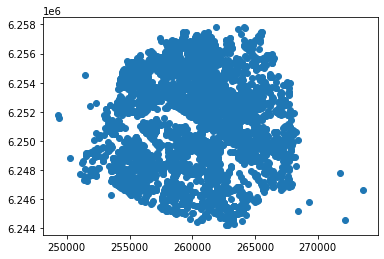

In [16]:
plt.plot(restaurants_data.x, restaurants_data.y, 'o')
plt.show()

## Simple Plot with Background Using contextily:

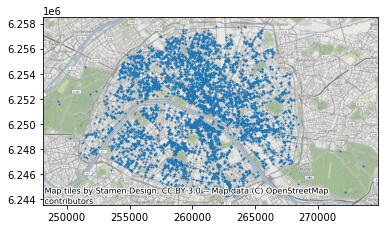

In [17]:
import contextily as ctx

fig, ax = plt.subplots()
ax.plot(restaurants_data.x, restaurants_data.y, 'o', markersize=1)
ctx.add_basemap(ax)
plt.show()

## Simple Plot Using GeoDataFrame: 

In [21]:
import geopandas as gpd

In [23]:
districts_data = gpd.read_file("paris_districts_utm.geojson")
districts_data.head(5)

,id,district_name,population,geometry
0,1,St-Germain-l'Auxerrois,1672,"POLYGON ((451922.133 5411438.484, 451922.080 5..."
1,2,Halles,8984,"POLYGON ((452278.419 5412160.893, 452192.407 5..."
2,3,Palais-Royal,3195,"POLYGON ((451553.806 5412340.522, 451528.058 5..."
3,4,Place-Vendôme,3044,"POLYGON ((451004.908 5412654.095, 450960.640 5..."
4,5,Gaillon,1345,"POLYGON ((451328.752 5412991.278, 451294.721 5..."


<AxesSubplot:>

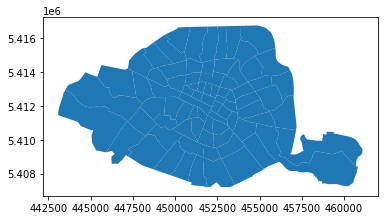

In [24]:
districts_data.plot()

In [25]:
districts_data.area

0     8.685379e+05
1     4.122371e+05
2     2.735494e+05
3     2.693111e+05
4     1.879097e+05
          ...     
75    1.294254e+06
76    8.061191e+05
77    1.486139e+06
78    1.598127e+06
79    2.089783e+06
Length: 80, dtype: float64

## Converting Pandas DataFrame to GeoPandas DataFrame:

C:\Users\Chris\anaconda3\envs\geospatial_analysis_env\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


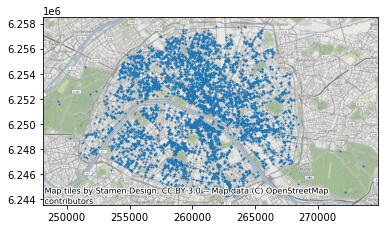

In [66]:
# Add a geometry column using the points_from_xy method to convert lat/lng to geometry then use GeoDataFrame to convert DataFrame to GeoDataFrame
restaurants_data_gpd = gpd.GeoDataFrame(restaurants_data, geometry=gpd.points_from_xy(restaurants_data.x, restaurants_data.y))

ax = restaurants_data_gpd.plot(markersize=1)
ctx.add_basemap(ax)
plt.show()

## Population Density Choropleth Map:

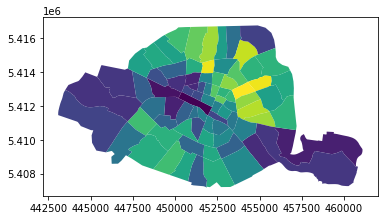

In [32]:
districts_data['population_density'] = districts_data.population / districts_data.area * 10**6

districts_data.plot(districts_data.population_density)
plt.show()

## Multiple Layers:

In [76]:
restaurants_data_african = restaurants_data_gpd[restaurants_data_gpd['type']=='African restaurant']

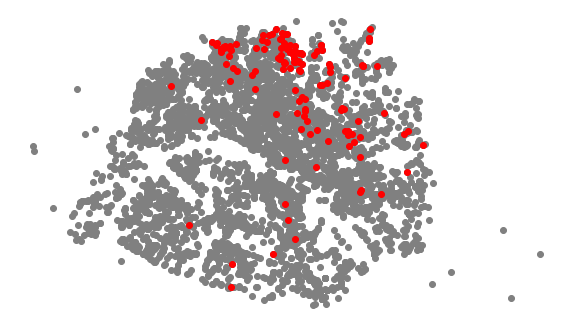

In [78]:
fig, ax = plt.subplots(figsize=(10,10))
restaurants_data_gpd.plot(ax=ax, color='grey')
restaurants_data_african.plot(ax=ax, color='red')
ax.set_axis_off()
plt.show()

## Using Shapely:

In [82]:
from shapely.geometry import Point

In [84]:
# Construct a point object for the Eiffel Tower
eiffel_tower = Point(255422.6, 6250868.9)

# Accessing the Montparnasse geometry (Polygon) and restaurant
districts_data_montparnasse = districts_data.loc[52, 'geometry']
resto = restaurants_data.loc[956, 'geometry']

# Is the Eiffel Tower located within the Montparnasse district?
print(eiffel_tower.within(districts_data_montparnasse))

# Does the Montparnasse district contains the restaurant?
print(districts_data_montparnasse.contains(resto))

# The distance between the Eiffel Tower and the restaurant?
print(eiffel_tower.distance(resto))

False
False
4431.459825587062


In [86]:
# Create a boolean Series
mask = districts_data.contains(eiffel_tower)

# Print the boolean Series
print(mask.head())

# Filter the districts with the boolean mask
print(districts_data[mask])

0    False
1    False
2    False
3    False
4    False
dtype: bool
Empty GeoDataFrame
Columns: [id, district_name, population, geometry, population_density]
Index: []


## Restaurants less than 1 km from the Eiffel Tower:

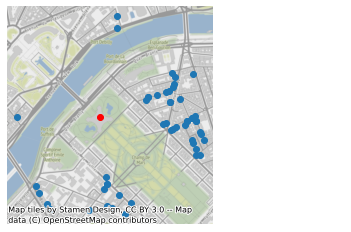

In [90]:
# The distance from each restaurant to the Eiffel Tower
dist_eiffel = restaurants_data_gpd.distance(eiffel_tower)

# Filter the restaurants for closer than 1 km
restaurants_eiffel = restaurants_data_gpd[dist_eiffel < 1000]

# Make a plot of the close-by restaurants
ax = restaurants_eiffel.plot()
geopandas.GeoSeries([eiffel_tower]).plot(ax=ax, color='red')
contextily.add_basemap(ax)
ax.set_axis_off()
plt.show()

## Spatial Joins:

In [99]:
stations_data = gpd.read_file('paris_sharing_bike_stations_utm.geojson')

stations_in_districts = gpd.sjoin(stations_data, districts_data, op='within')

stations_in_districts.head(5)

,name,bike_stands,available_bikes,geometry,index_right,id,district_name,population,population_density
0,14002 - RASPAIL QUINET,44,4,POINT (450804.449 5409797.268),52,53,Montparnasse,18570,16497.225232
143,14112 - FAUBOURG SAINT JACQUES CASSINI,16,0,POINT (451419.447 5409421.529),52,53,Montparnasse,18570,16497.225232
293,14033 - DAGUERRE GASSENDI,38,1,POINT (450708.228 5409406.941),52,53,Montparnasse,18570,16497.225232
346,14006 - SAINT JACQUES TOMBE ISSOIRE,22,0,POINT (451340.026 5409124.575),52,53,Montparnasse,18570,16497.225232
429,14111 - DENFERT-ROCHEREAU CASSINI,24,8,POINT (451274.511 5409609.731),52,53,Montparnasse,18570,16497.225232


## Tree Density Choropleth:

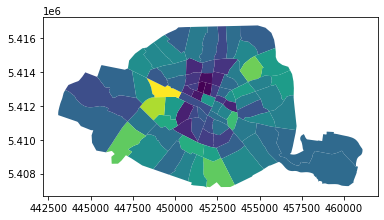

In [117]:
# Read the trees data
trees_data = gpd.read_file("paris_trees_small.gpkg")

# Spatial join of the trees and districts datasets
joined = gpd.sjoin(trees_data, districts_data, op='within')

# Calculate the number of trees in each district
trees_by_district = joined.groupby('district_name').size()

# Convert the series to a DataFrame and specify column name
trees_by_district = trees_by_district.to_frame(name='n_trees')

# Merge the 'districts' and 'trees_by_district' dataframes
districts_trees = pd.merge(districts_data, trees_by_district, on='district_name')

# Add a column with the tree density
districts_trees['n_trees_per_area'] = districts_trees['n_trees'] / districts_trees.geometry.area

# Make of map of the districts colored by 'n_trees_per_area'
districts_trees.plot(column='n_trees_per_area')
plt.show()